In [1]:
import pandas as pd
import numpy as np
import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()
    # colab 사용자는 system_name이 'Linux'로 확인

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux
        # colab에서는 runtime을 <꼭> 재시작 해야함.
        # 런타임을 재시작 하지 않고 폰트 설치를 하면 기본 설정 폰트가 로드되어 한글이 깨짐.
        !apt-get update -qq
        !apt-get install fonts-nanum -qq  > /dev/null

        import matplotlib.font_manager as fm

        fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
        font = fm.FontProperties(fname=fontpath, size=9)
        fm._rebuild()
        font_family = "NanumBarunGothic"
    return font_family

In [3]:
# 시각화를 위한 폰트설정
# 위에서 만든 함수를 통해 시스템 폰트를 불러와서 font_family 라는 변수에 할당.
a = get_font_family()
# 폰트설정
import matplotlib.pyplot as plt 
plt.rc("font", family = a)
# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)
# ggplot으로 그래프 스타일 설정
#plt.style.use("ggplot")


In [5]:
df = pd.read_csv('./실전db.csv')

In [6]:
df.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR


In [7]:
df.sort_values(by="JOIN_DATE").head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
176320,1071641,1970-01-01,CC,221045,A,2020-04-03,1,GN
625539,1686813,1970-01-01,CC,223023,A,2020-10-02,1,YD
226658,859401,1970-01-01,CC,102276,B,2020-04-27,1,SC
226415,654237,1970-01-01,CC,181777,C,2020-04-27,1,BF
226042,1552374,1970-01-01,CC,28018,C,2020-04-26,1,JRR


### 2013년 이후 데이터 필터링

In [8]:
df = df[df["JOIN_DATE"]>="2013-01-01"]
display(df)

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR
...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J


In [9]:
df["DATE"].min()

'2020-01-01'

In [10]:
df["USER_ID"].nunique()

165161

### 코호트 분석 시작

In [11]:
temp2 = df.copy()

In [12]:
temp2.groupby(["USER_ID","DATE"])["COUNT"].count()

USER_ID  DATE      
224      2020-01-12    1
         2020-12-09    1
232      2020-01-19    1
         2020-01-26    1
         2020-01-27    1
                      ..
1830551  2020-12-31    1
1830570  2020-12-31    1
1830580  2020-12-31    1
1830589  2020-12-31    1
1830598  2020-12-31    1
Name: COUNT, Length: 878178, dtype: int64

In [13]:
#temp2.columns

In [14]:
temp2.drop(['JOIN_DATE','D_TYPE','STORE_ID','GOODS_TYPE','AD1'],
        axis=1,inplace=True)
temp2.head()

,USER_ID,DATE,COUNT
0,2858,2020-01-01,1
1,5647,2020-01-01,1
2,33314,2020-01-01,1
3,37001,2020-01-01,1
4,37819,2020-01-01,1


In [15]:
temp2["COUNT"].sort_values(ascending=False)

729776    61
748372    59
751974    58
726277    55
767392    53
          ..
583528     1
583527     1
583526     1
583525     1
0          1
Name: COUNT, Length: 878178, dtype: int64

In [16]:
temp2[temp2["COUNT"] == 61]

,USER_ID,DATE,COUNT
729776,999665,2020-11-07,61


In [17]:
temp2["USER_ID"].dtypes

dtype('int64')

### 1. 사용일자(DATE) 칼럼으로 단위 기간 만들기

In [18]:
temp2["DATE"]=pd.to_datetime(temp2["DATE"])

In [19]:
# DATE컬럼 데이터를 시계열 데이터로 만들고 새로운 컬럼 추가. 
temp2['OrderPeriod']=temp2['DATE'].dt.strftime('%Y-%m')

In [20]:
temp2.head()

,USER_ID,DATE,COUNT,OrderPeriod
0,2858,2020-01-01,1,2020-01
1,5647,2020-01-01,1,2020-01
2,33314,2020-01-01,1,2020-01
3,37001,2020-01-01,1,2020-01
4,37819,2020-01-01,1,2020-01


In [21]:
#temp2[tmep2["USER_ID"] == 1360898]

### 2. 유저의 첫번째 사용일 토대로 유저별 코호트 그룹 설정하기
- 동일한 경험이란 첫 번째 사용일.
- 각각의 raw에 고객ID별 첫 번째 주문일자를 추가.

In [22]:
temp2.set_index('USER_ID',inplace=True)
temp2.head()

,DATE,COUNT,OrderPeriod
USER_ID,,,
2858,2020-01-01,1,2020-01
5647,2020-01-01,1,2020-01
33314,2020-01-01,1,2020-01
37001,2020-01-01,1,2020-01
37819,2020-01-01,1,2020-01


In [23]:
len(temp2)

878178

In [24]:
FirstOrder=temp2.groupby(temp2.index)['DATE'].min()
FirstOrder.head()

USER_ID
224   2020-01-12
232   2020-01-19
342   2020-10-31
565   2020-08-27
729   2020-09-05
Name: DATE, dtype: datetime64[ns]

In [25]:
len(FirstOrder)

165161

In [26]:
FirstOrder=FirstOrder.dt.strftime('%Y-%m')
FirstOrder.head()

USER_ID
224    2020-01
232    2020-01
342    2020-10
565    2020-08
729    2020-09
Name: DATE, dtype: object

In [27]:
temp2['FirstOrder']=FirstOrder
temp2.reset_index(inplace=True)
temp2.head()

,USER_ID,DATE,COUNT,OrderPeriod,FirstOrder
0,2858,2020-01-01,1,2020-01,2020-01
1,5647,2020-01-01,1,2020-01,2020-01
2,33314,2020-01-01,1,2020-01,2020-01
3,37001,2020-01-01,1,2020-01,2020-01
4,37819,2020-01-01,1,2020-01,2020-01


In [28]:
temp2[temp2["USER_ID"] == 33314]

,USER_ID,DATE,COUNT,OrderPeriod,FirstOrder
2,33314,2020-01-01,1,2020-01,2020-01
235092,33314,2020-05-01,1,2020-05,2020-01
238746,33314,2020-05-03,1,2020-05,2020-01


In [29]:
display(temp2)

,USER_ID,DATE,COUNT,OrderPeriod,FirstOrder
0,2858,2020-01-01,1,2020-01,2020-01
1,5647,2020-01-01,1,2020-01,2020-01
2,33314,2020-01-01,1,2020-01,2020-01
3,37001,2020-01-01,1,2020-01,2020-01
4,37819,2020-01-01,1,2020-01,2020-01
...,...,...,...,...,...
878173,1830551,2020-12-31,1,2020-12,2020-12
878174,1830570,2020-12-31,1,2020-12,2020-12
878175,1830580,2020-12-31,1,2020-12,2020-12
878176,1830589,2020-12-31,1,2020-12,2020-12


### 3. 코호트 그룹과 주문기간으로 데이터 집계하기


In [28]:
grouped = temp2.groupby(['FirstOrder', 'OrderPeriod'])

In [29]:
len(grouped)

78

In [30]:
cohorts=grouped['USER_ID'].nunique()

In [31]:
cohorts=cohorts.reset_index()
#cohorts.head()


In [32]:
len(cohorts)

78

#### RFM과 Cohort분석을 하기 위해 CSV파일로 추출 

In [33]:
#cohorts.to_csv("cohort_chart.csv")

In [34]:
cohorts.rename({'USER_ID':'TotalUsers'},axis=1,inplace=True)
cohorts.head()

,FirstOrder,OrderPeriod,TotalUsers
0,2020-01,2020-01,26369
1,2020-01,2020-02,9404
2,2020-01,2020-03,6886
3,2020-01,2020-04,7060
4,2020-01,2020-05,7202


In [35]:
each_period=cohorts['FirstOrder'].value_counts().sort_index()
each_period

2020-01    12
2020-02    11
2020-03    10
2020-04     9
2020-05     8
2020-06     7
2020-07     6
2020-08     5
2020-09     4
2020-10     3
2020-11     2
2020-12     1
Name: FirstOrder, dtype: int64

In [36]:
cohortperiod=[]

for x in each_period: 
    for y in range(x):
        cohortperiod.append(y)

In [37]:
cohorts['CohortPeriod']=cohortperiod
cohorts.head(20)

,FirstOrder,OrderPeriod,TotalUsers,CohortPeriod
0,2020-01,2020-01,26369,0
1,2020-01,2020-02,9404,1
2,2020-01,2020-03,6886,2
3,2020-01,2020-04,7060,3
4,2020-01,2020-05,7202,4
5,2020-01,2020-06,6592,5
6,2020-01,2020-07,6672,6
7,2020-01,2020-08,5836,7
8,2020-01,2020-09,5008,8
9,2020-01,2020-10,5821,9


In [38]:
cohorts.set_index(['FirstOrder','CohortPeriod'],inplace=True)
cohorts.head()

OrderPeriod  TotalUsers
FirstOrder CohortPeriod                        
2020-01    0                2020-01       26369
           1                2020-02        9404
           2                2020-03        6886
           3                2020-04        7060
           4                2020-05        7202

In [39]:
cohorts=cohorts['TotalUsers'].unstack(1)
cohorts

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11
FirstOrder,,,,,,,,,,,,
2020-01,26369.0,9404.0,6886.0,7060.0,7202.0,6592.0,6672.0,5836.0,5008.0,5821.0,5479.0,3882.0
2020-02,15285.0,4178.0,3683.0,3583.0,3244.0,3231.0,2858.0,2450.0,2762.0,2593.0,1923.0,NaN
2020-03,12565.0,3928.0,3231.0,2780.0,2757.0,2413.0,2209.0,2346.0,2083.0,1645.0,NaN,NaN
2020-04,12847.0,3532.0,2864.0,2774.0,2308.0,1971.0,2261.0,1946.0,1446.0,NaN,NaN,NaN
2020-05,13798.0,3539.0,3072.0,2458.0,2069.0,2415.0,2112.0,1459.0,NaN,NaN,NaN,NaN
2020-06,13148.0,3616.0,2699.0,2162.0,2353.0,2159.0,1449.0,NaN,NaN,NaN,NaN,NaN
2020-07,13959.0,3367.0,2459.0,2612.0,2342.0,1550.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-08,11908.0,2783.0,2498.0,2158.0,1606.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09,10158.0,2922.0,2224.0,1636.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
cohorts[0]


FirstOrder
2020-01    26369.0
2020-02    15285.0
2020-03    12565.0
2020-04    12847.0
2020-05    13798.0
2020-06    13148.0
2020-07    13959.0
2020-08    11908.0
2020-09    10158.0
2020-10    13320.0
2020-11    12914.0
2020-12     8890.0
Name: 0, dtype: float64

In [41]:
user_retention=cohorts.divide(cohorts[0],axis=0)
user_retention


CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11
FirstOrder,,,,,,,,,,,,
2020-01,1.0,0.356631,0.261140,0.267739,0.273124,0.249991,0.253024,0.221320,0.189920,0.220752,0.207782,0.147218
2020-02,1.0,0.273340,0.240955,0.234413,0.212234,0.211384,0.186981,0.160288,0.180700,0.169643,0.125810,NaN
2020-03,1.0,0.312614,0.257143,0.221250,0.219419,0.192041,0.175806,0.186709,0.165778,0.130919,NaN,NaN
2020-04,1.0,0.274928,0.222931,0.215926,0.179653,0.153421,0.175994,0.151475,0.112555,NaN,NaN,NaN
2020-05,1.0,0.256486,0.222641,0.178142,0.149949,0.175025,0.153066,0.105740,NaN,NaN,NaN,NaN
2020-06,1.0,0.275023,0.205278,0.164436,0.178963,0.164207,0.110207,NaN,NaN,NaN,NaN,NaN
2020-07,1.0,0.241206,0.176159,0.187119,0.167777,0.111039,NaN,NaN,NaN,NaN,NaN,NaN
2020-08,1.0,0.233708,0.209775,0.181223,0.134867,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09,1.0,0.287655,0.218941,0.161055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


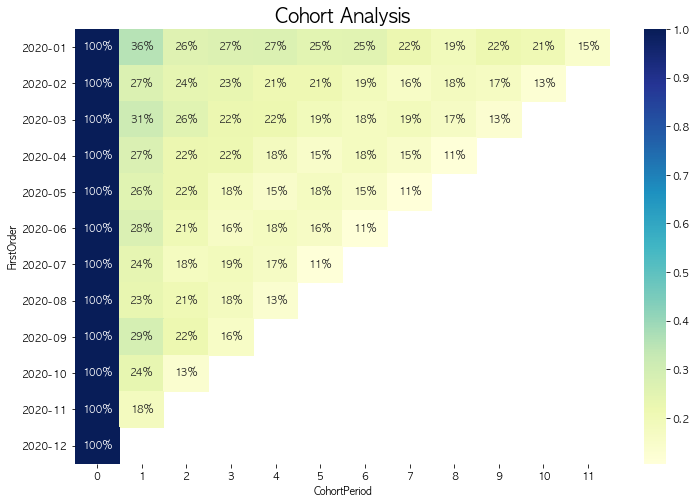

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plt.figure(figsize=(12, 8))
plt.title('Cohort Analysis', fontsize=19)
sns.heatmap(user_retention, cmap ="YlGnBu", annot=True, fmt='.0%')
plt.show()

표를 가로로 보면 유저의 라이프 사이클을 볼 수 있고 세로로 보면 프로덕트의 라이프 사이클을 볼 수 있다. 

RFM 분석을 하기 위해 필요한 컬럼: <br>
1. 날짜 데이터. 있음 <br>
2. USER ID 있음 <br>
3. Quantity <br>
4. Unit Price <br>

# 추가 분석

In [43]:
# temp3 = df.copy()

In [44]:
# temp3['D_TYPE_Num'] = 0
# temp3.loc[temp3["D_TYPE"] == "AA",'D_TYPE_Num'] = 1

In [45]:
# temp3.loc[temp3["D_TYPE"] == "BB", 'D_TYPE_Num'] = 2

In [46]:
# temp3.loc[temp3["D_TYPE"] == "CC", "D_TYPE_Num"] = 3

In [47]:
# temp3

In [48]:
# data = temp3[["D_TYPE_Num", "COUNT"]]
# data = pd.DataFrame(data, columns=["D_TYPE_Num","COUNT"])
# corr = data.corr()
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True
# plt.figure(figsize=(14,8))
# plt.title('D_TYPE열과 COUNT열의 상관계수', fontsize=18)
# sns.heatmap(corr, mask=mask, annot=True, cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
# plt.show()

In [49]:
# len(temp3[temp3["D_TYPE_Num"]==3])

In [50]:
# len(temp3)

In [51]:
# temp3_sub = temp3[temp3["D_TYPE_Num"]==3]

In [52]:
# temp3_sub

In [53]:
# temp3_sub[temp3_sub["COUNT"] == 1]

In [54]:
# len(temp3_sub[temp3_sub["COUNT"] == 1])

# 생각정리

필요한 컬럼 
1. Date컬럼 (o)
2. User_ID (o)
3. 결제 금액? (x)
4. 방문 횟수 (o)<br>

모두의 컴퍼니 가격 정책은 상품1의 가격, 상품2의 가격 처럼 떨어지지 않는다. 
Goods_Type은 
결제금액을 범주화 시켜둔것? 
근거는? 

역삼역 2번 출구
평일 당일권: 23,000

RFM 첫 단계 분석 절차 <br>
1. 고객 아이디 추출 
2. 각 고객별로 구매 금액이 얼마인지 알아보자. 

아이템 : A,B,C,D<br>
수량 : User가 A라는 상품을 얼마나 시켰냐? B라는 상품을 얼마나 시켰냐?<br>
가격 : <br>
A: 미정 <br>
B: 미정 <br>
C: 미정 <br>
D: 미정 <br>

In [55]:
# temp1 = df.copy()

Cohort
RFM : Recency, Frequency, Monetary. 가장 최근에, 얼마나 자주, 돈을 지불했는가. 
Frequency
(1-5)1점
(6-10) 2점
(11-15)3점 
Recency 
기준일 1달 이내 5점 
2달 이내 4점 
Monetary 
5000만원 이상 지불 4점 
3000만원 이상 지불 3점 
LTV
예) 
유저1 124
유저2 555 관리혜야하는 고객 
cohort, rfm, ltv --> 어떤 user_id 중요한 Id --> 액션 프랜 

In [56]:
# temp1.head()